In [1]:
import sys
import os
current_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
sys.path.append(parent_dir)
import torch
device = "cuda"

# System Usage

## Units

In [2]:
import system.units as units
print(units.UnitSystem.akma())
print(units.UnitSystem.gmx())

UnitSystem(L=1e-10 m/uL, E=6.95e-21 J/uE, M=1.66e-27 kg/um, kB=0.00199 uE/K, Q=0.0549 e/uQ)
UnitSystem(L=1e-09 m/uL, E=1.66e-21 J/uE, M=1.66e-27 kg/um, kB=0.00831 uE/K, Q=0.0848 e/uQ)


## Topology

In [3]:
import system.topology as topology
arity_table = (
    ["bond", "mie"],
    [2,      2]
)
top = topology.Topology(arity_table)
print(top)

Topology(bond (arity 2), mie (arity 2))


In [4]:
top.add(2,"bond",(0,1))
top.add(2,"bond",(2,3))

top.add(2,"mie",(1,2))
top.add(2,"mie",(1,3))

top.add(2,"mie",(0,2))
top.add(2,"mie",(0,3))

In [5]:
print("Harmonic Bond Top")

print(top.get(2,"bond"))
print(type(top.get(2,"bond")))

print(top.get_tensor(2,"bond"))
print(type(top.get_tensor(2,"bond")))

print("\nMie Top")

print(top.get(2,"mie"))
print(type(top.get(2,"mie")))

print(top.get_tensor(2,"mie"))
print(type(top.get_tensor(2,"mie")))

Harmonic Bond Top
{(0, 1), (2, 3)}
<class 'set'>
tensor([[0, 1],
        [2, 3]], device='cuda:0')
<class 'torch.Tensor'>

Mie Top
{(1, 2)}
<class 'set'>
tensor([[1, 2]], device='cuda:0')
<class 'torch.Tensor'>


## Box

In [6]:
import system.box as box
b = box.Box([20,20,20],["p","p","p"])
print(b)

Box(20p, 20p, 20p)


## Energy

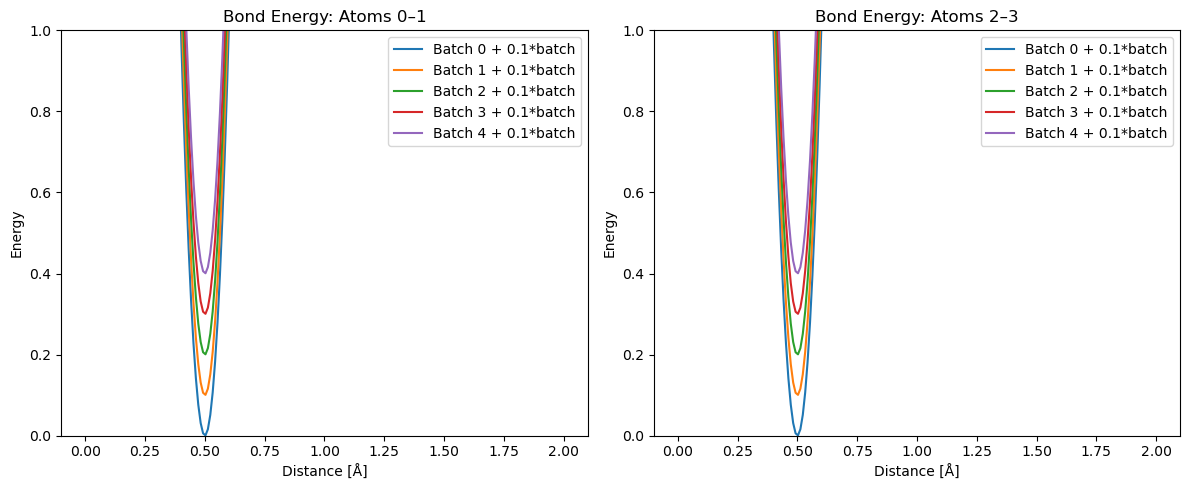

In [9]:
import forces.twobody as twobody
import matplotlib.pyplot as plt
HB = twobody.Harmonic_Bond(r_0 = 0.5, kappa = 100,label = "bond")
pos = torch.zeros(5,4,3,device=device) # B x N x 3
pos[:,:,-1] = torch.arange(0,4,device=device)

B = 5
r_vals = torch.linspace(0.0, 2.0, 200, device=device)
energies = []

for batch in range(B):
    E_bond_01 = []
    E_bond_23 = []

    for r in r_vals:
        pos = torch.ones(B, 4, 3, device=device)
        pos*=10
        pos[batch, 1, -1] = 10+r         # Move atom 1 along z-axis
        pos[batch, 3, -1] = 10+r         # Move atom 3 along z-axis

        E = HB.energy(pos, top, b,{})  # (B, M)
        E_bond_01.append(E[batch, 0].item())
        E_bond_23.append(E[batch, 1].item())

    energies.append((E_bond_01, E_bond_23))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for batch, (E01, E23) in enumerate(energies):
    axs[0].plot(r_vals.cpu(), torch.tensor(E01)+0.1*batch, label=f'Batch {batch} + 0.1*batch')
    axs[1].plot(r_vals.cpu(), torch.tensor(E23)+0.1*batch, label=f'Batch {batch} + 0.1*batch')

axs[0].set_title('Bond Energy: Atoms 0–1')
axs[0].set_xlabel('Distance [Å]')
axs[0].set_ylabel('Energy')
axs[0].legend()
axs[0].set_ylim(0,1)

axs[1].set_title('Bond Energy: Atoms 2–3')
axs[1].set_xlabel('Distance [Å]')
axs[1].set_ylabel('Energy')
axs[1].legend()
axs[1].set_ylim(0,1)

plt.tight_layout()
plt.show()


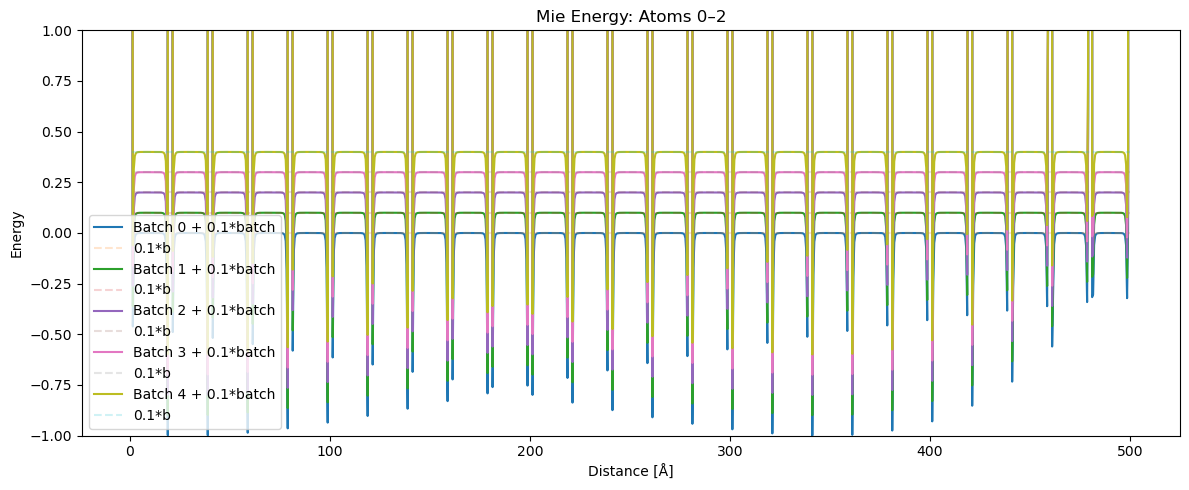

In [10]:
mie = twobody.Mie(n = 12, sigma = 1, epsilon = 1,label = "mie")
pos = torch.zeros(5,4,3,device=device) # B x N x 3
pos[:,:,-1] = torch.arange(0,4,device=device)

B = 5
r_vals = torch.linspace(0.9, 500.0, 1000, device=device)
energies = []

for batch in range(B):
    E_mie = []

    for r in r_vals:
        pos = torch.ones(B, 4, 3, device=device)
        pos*=10
        pos[batch, 2, -1] = 10+r         # Move atom 3 along z-axis

        E = mie.energy(pos, top, b,{})  # (B, M)
        E_mie.append(E[batch, 0].item())

    energies.append(E_mie)

# Plotting
fig, axs = plt.subplots(1, 1, figsize=(12, 5))

for batch, (E_mie) in enumerate(energies):
    axs.plot(r_vals.cpu(), torch.tensor(E_mie)+0.1*batch, label=f'Batch {batch} + 0.1*batch')
    axs.plot(r_vals.cpu(), torch.ones_like(r_vals).cpu()*0.1*batch, label=f'0.1*b',linestyle='dashed',alpha=0.2)
axs.set_title('Mie Energy: Atoms 0–2')
axs.set_xlabel('Distance [Å]')
axs.set_ylabel('Energy')
axs.legend()
axs.set_ylim(-1,1)

plt.tight_layout()
plt.show()


In [11]:
B, N = 1, 4

# Atom layout before centering
pos = torch.zeros(B, N, 3, device=device)

# Lay out two dimers linearly in x with spacing
bond_length = 1.0
dimer_spacing = 0.9

pos[:, 1, 0] = bond_length
pos[:, 2, 0] = bond_length + dimer_spacing
pos[:, 3, 0] = 2 * bond_length + dimer_spacing

# Compute molecule center (mean over atom positions)
mol_center = pos.mean(dim=1, keepdim=True)  # shape: (B, 1, 3)

# Assume b.Lx, b.Ly, b.Lz are scalar floats or tensors
box_center = torch.tensor([[b.Lx, b.Ly, b.Lz]], device=device) / 2  # shape: (1, 3)

# Shift all positions so center aligns with box center
pos = pos - mol_center + box_center

import system.system as sys

mom = torch.zeros(B,N,3,device=device)
mass = torch.ones(4)
energy_dict = {"mie":mie, "bond":HB}
u = units.UnitSystem()
b =  box.Box([10,10,10],["p","p","p"])
S = sys.System(pos, mom, mass, top, b, energy_dict, u)
print(S)
print(S.potential_energy())
S.compile_force_fn()
print(S.force())

System(Batches: 1, Atoms: 4, Interactions: 2, Box: Box(10p, 10p, 10p), Units: UnitSystem(L=1 m/uL, E=1 J/uE, M=1 kg/um, kB=1 uE/K, Q=1 e/uQ))
tensor([56.6362], device='cuda:0')
tensor([[[ 100.0000,   -0.0000,   -0.0000],
         [-238.6606,   -0.0000,   -0.0000],
         [ 238.6606,   -0.0000,   -0.0000],
         [-100.0000,   -0.0000,   -0.0000]]], device='cuda:0')


In [12]:
B, N = 1, 4

# Atom layout before centering
pos = torch.zeros(B, N, 3, device=device)

# Lay out two dimers linearly in x with spacing
bond_length = 1.0
dimer_spacing = 1.1

pos[:, 1, 0] = bond_length
pos[:, 2, 0] = bond_length + dimer_spacing
pos[:, 3, 0] = 2 * bond_length + dimer_spacing

# Compute molecule center (mean over atom positions)
mol_center = pos.mean(dim=1, keepdim=True)  # shape: (B, 1, 3)

# Assume b.Lx, b.Ly, b.Lz are scalar floats or tensors
box_center = torch.tensor([[b.Lx, b.Ly, b.Lz]], device=device) / 2  # shape: (1, 3)

# Shift all positions so center aligns with box center
pos = pos - mol_center + box_center

import system.system as sys

mom = torch.zeros(B,N,3,device=device)
mass = torch.ones(4)
energy_dict = {"mie":mie, "bond":HB}
u = units.UnitSystem()
b =  box.Box([10,10,10],["p","p","p"])
S = sys.System(pos, mom, mass, top, b, energy_dict, u)
print(S)
print(S.potential_energy())
S.compile_force_fn()
print(S.force())

System(Batches: 1, Atoms: 4, Interactions: 2, Box: Box(10p, 10p, 10p), Units: UnitSystem(L=1 m/uL, E=1 J/uE, M=1 kg/um, kB=1 uE/K, Q=1 e/uQ))
tensor([49.0166], device='cuda:0')
tensor([[[ 100.0000,   -0.0000,   -0.0000],
         [-101.5880,   -0.0000,   -0.0000],
         [ 101.5881,   -0.0000,   -0.0000],
         [-100.0000,   -0.0000,   -0.0000]]], device='cuda:0')


In [13]:
B, N = 1, 4

# Atom layout before centering
pos = torch.zeros(B, N, 3, device=device)

# Lay out two dimers linearly in x with spacing
bond_length = 1.0
dimer_spacing = 2**(1/6)

pos[:, 1, 0] = bond_length
pos[:, 2, 0] = bond_length + dimer_spacing
pos[:, 3, 0] = 2 * bond_length + dimer_spacing

# Compute molecule center (mean over atom positions)
mol_center = pos.mean(dim=1, keepdim=True)  # shape: (B, 1, 3)

# Assume b.Lx, b.Ly, b.Lz are scalar floats or tensors
box_center = torch.tensor([[b.Lx, b.Ly, b.Lz]], device=device) / 2  # shape: (1, 3)

# Shift all positions so center aligns with box center
pos = pos - mol_center + box_center

import system.system as sys

mom = torch.zeros(B,N,3,device=device)
mass = torch.ones(4)
energy_dict = {"mie":mie, "bond":HB}
u = units.UnitSystem()
b =  box.Box([10,10,10],["p","p","p"])
S = sys.System(pos, mom, mass, top, b, energy_dict, u)
print(S)
print(S.potential_energy())
S.compile_force_fn()
print(S.force())

System(Batches: 1, Atoms: 4, Interactions: 2, Box: Box(10p, 10p, 10p), Units: UnitSystem(L=1 m/uL, E=1 J/uE, M=1 kg/um, kB=1 uE/K, Q=1 e/uQ))
tensor([49.], device='cuda:0')
tensor([[[ 100.0000,   -0.0000,   -0.0000],
         [-100.0000,   -0.0000,   -0.0000],
         [ 100.0000,   -0.0000,   -0.0000],
         [-100.0000,   -0.0000,   -0.0000]]], device='cuda:0')


In [14]:
B, N = 1, 4

# Atom layout before centering
pos = torch.zeros(B, N, 3, device=device)

# Lay out two dimers linearly in x with spacing
bond_length = 0.51
dimer_spacing = 2**(1/6) + 0.1

pos[:, 1, 0] = bond_length
pos[:, 2, 0] = bond_length + dimer_spacing
pos[:, 3, 0] = 2 * bond_length + dimer_spacing

# Compute molecule center (mean over atom positions)
mol_center = pos.mean(dim=1, keepdim=True)  # shape: (B, 1, 3)

# Assume b.Lx, b.Ly, b.Lz are scalar floats or tensors
box_center = torch.tensor([[b.Lx, b.Ly, b.Lz]], device=device) / 2  # shape: (1, 3)

# Shift all positions so center aligns with box center
pos = pos - mol_center + box_center

import system.system as sys

mom = torch.ones(B,N,3,device=device)
mass = 2*torch.ones(4,device=device)
energy_dict = {"mie":mie, "bond":HB}
u = units.UnitSystem()
b =  box.Box([10,10,10],["p","p","p"])
S = sys.System(pos, mom, mass, top, b, energy_dict, u)
print(S)
print(S.potential_energy())
S.compile_force_fn()
print(S.force())

System(Batches: 1, Atoms: 4, Interactions: 2, Box: Box(10p, 10p, 10p), Units: UnitSystem(L=1 m/uL, E=1 J/uE, M=1 kg/um, kB=1 uE/K, Q=1 e/uQ))
tensor([-0.8194], device='cuda:0')
tensor([[[ 2.0000, -0.0000, -0.0000],
         [ 0.3573, -0.0000, -0.0000],
         [-0.3573, -0.0000, -0.0000],
         [-2.0000, -0.0000, -0.0000]]], device='cuda:0')


In [15]:
S.velocity()

tensor([[[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]]], device='cuda:0')

In [16]:
from integrators import NVE as NVE

In [17]:
integrator = NVE.NVE(0.1)

In [18]:
integrator.step(S)

In [19]:
pos

tensor([[[3.8788, 5.0000, 5.0000],
         [4.3888, 5.0000, 5.0000],
         [5.6112, 5.0000, 5.0000],
         [6.1212, 5.0000, 5.0000]]], device='cuda:0')